In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical
from sklearn.metrics import make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv')

In [3]:
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test], axis=0)

In [4]:
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,test
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,0
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,0
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,0
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,0
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,0


In [5]:
df[df.columns[df.isna().mean() > 0]].isna().mean()

SulphurDioxide_SO2_column_number_density          0.200733
SulphurDioxide_SO2_column_number_density_amf      0.200733
SulphurDioxide_SO2_slant_column_number_density    0.200733
SulphurDioxide_cloud_fraction                     0.200733
SulphurDioxide_sensor_azimuth_angle               0.200733
                                                    ...   
Cloud_sensor_azimuth_angle                        0.006288
Cloud_sensor_zenith_angle                         0.006288
Cloud_solar_azimuth_angle                         0.006288
Cloud_solar_zenith_angle                          0.006288
emission                                          0.235577
Length: 71, dtype: float64

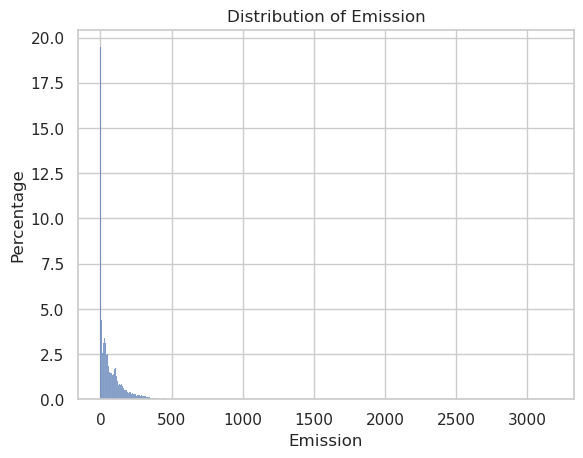

In [6]:
sns.set(style="whitegrid")

plot = sns.histplot(data=df, x='emission', stat='percent', palette="Set1")

plot.set_title('Distribution of Emission')
plt.xlabel('Emission')
plt.ylabel('Percentage')

plt.show()

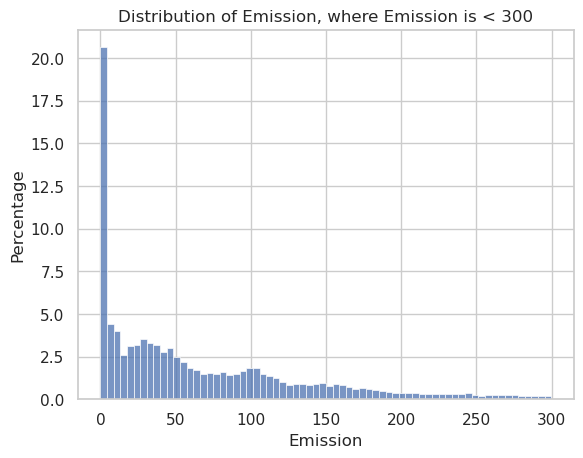

In [7]:
sns.set(style="whitegrid")

plot = sns.histplot(data=df.loc[df['emission'] < 300], x='emission', stat='percent', palette="Set1")

plot.set_title('Distribution of Emission, where Emission is < 300')
plt.xlabel('Emission')
plt.ylabel('Percentage')

plt.show()

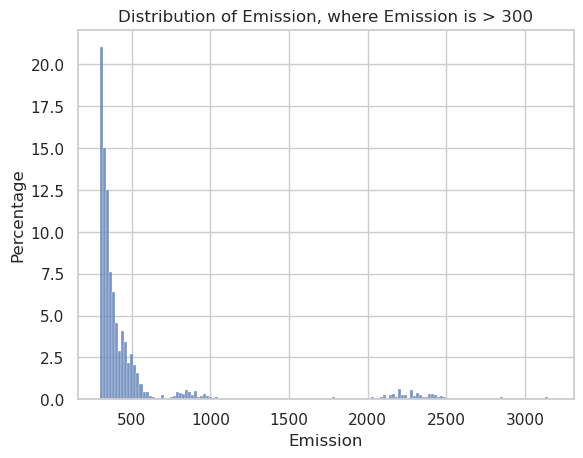

In [8]:
sns.set(style="whitegrid")

plot = sns.histplot(data=df.loc[df['emission'] > 300], x='emission', stat='percent', palette="Set1")

plot.set_title('Distribution of Emission, where Emission is > 300')
plt.xlabel('Emission')
plt.ylabel('Percentage')

plt.show()

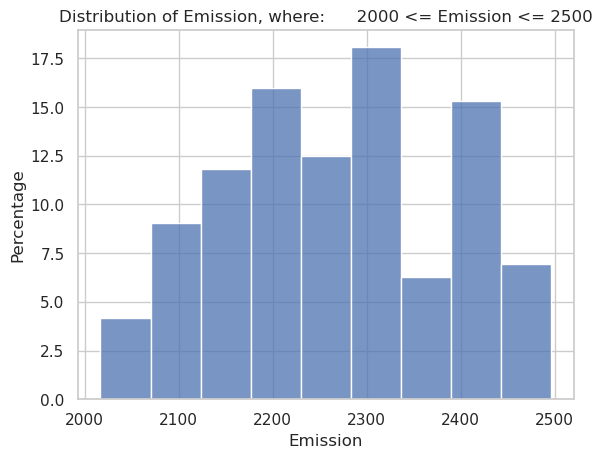

In [9]:
sns.set(style="whitegrid")

plot = sns.histplot(data=df.loc[(df['emission'] > 2000) & (df['emission'] < 2500)], x='emission', stat='percent', palette="Set1")

plot.set_title('Distribution of Emission, where:      2000 <= Emission <= 2500')
plt.xlabel('Emission')
plt.ylabel('Percentage')

plt.show()

In [10]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w')

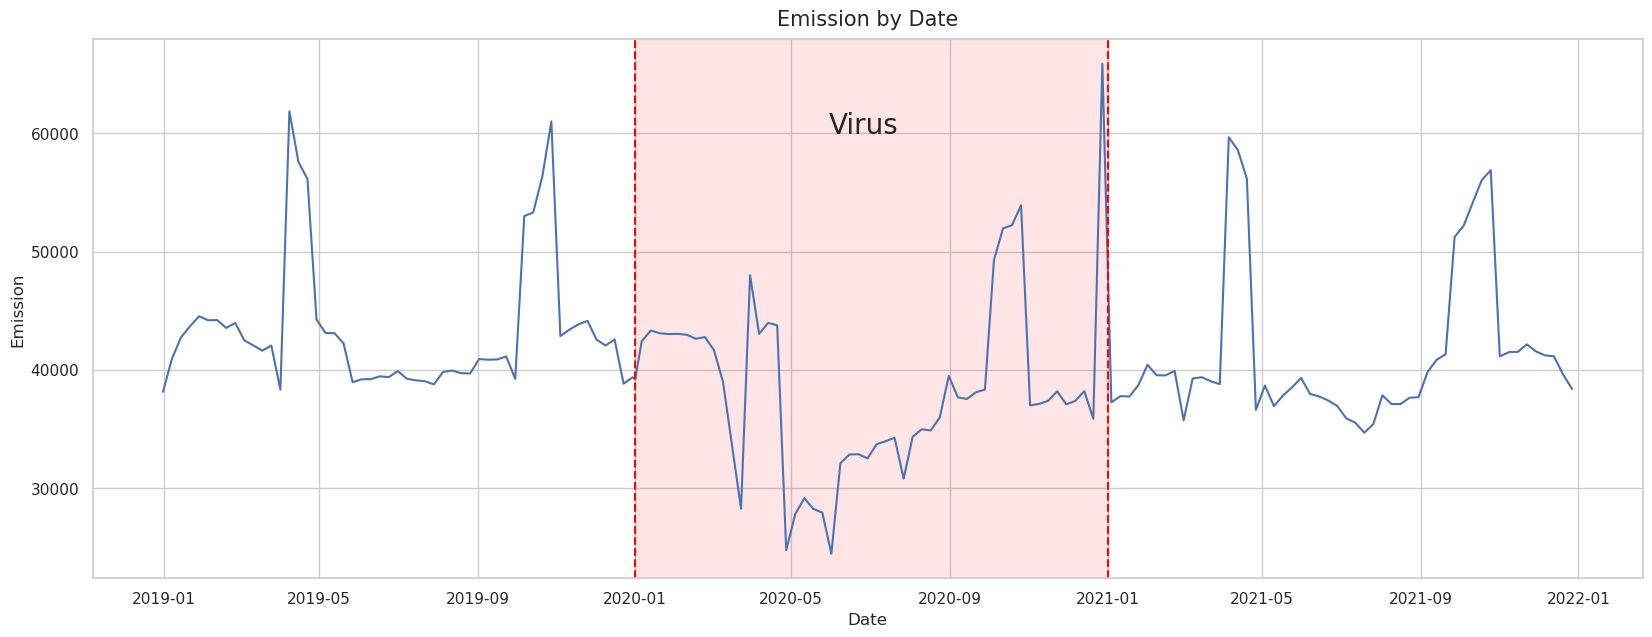

In [11]:
filtered_data = df.loc[df['test'] == 0]
grouped_data = filtered_data.groupby(['date'])['emission'].sum()

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.lineplot(data=grouped_data.reset_index(), x='date', y='emission', ax=ax)

ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='red', alpha=0.1)
ax.axvline(pd.Timestamp('2020-01-01'), linestyle="--", color='red')
ax.axvline(pd.Timestamp('2021-01-01'), linestyle="--", color='red')

ax.text(pd.Timestamp('2020-05-30'), 60000, "Virus", size=20)

ax.set_xlabel('Date')
ax.set_ylabel('Emission')
ax.set_title('Emission by Date', size=15, pad=10)

plt.show()

In [12]:
features = df.columns[1:75]

target = 'emission'

In [13]:
missing_ratios = df[features].isnull().mean()
columns_to_drop = missing_ratios[missing_ratios > 0.4].index
df = df.drop(columns_to_drop, axis=1)

In [14]:
features = df.columns[1:68]

imputer = SimpleImputer()
df[features] = imputer.fit_transform(df[features])

In [15]:
avg_emission_non_virus = df[df['year'].isin((2019, 2021))].groupby('week_no')['emission'].mean()
avg_emission_virus = df[df['year'] == 2020].groupby('week_no')['emission'].mean()

ratios_for_weeks = avg_emission_non_virus / avg_emission_virus

virus_year_rows = df['year'] == 2020
df.loc[virus_year_rows, 'emission'] *= ratios_for_weeks.reindex(df[virus_year_rows]['week_no']).values

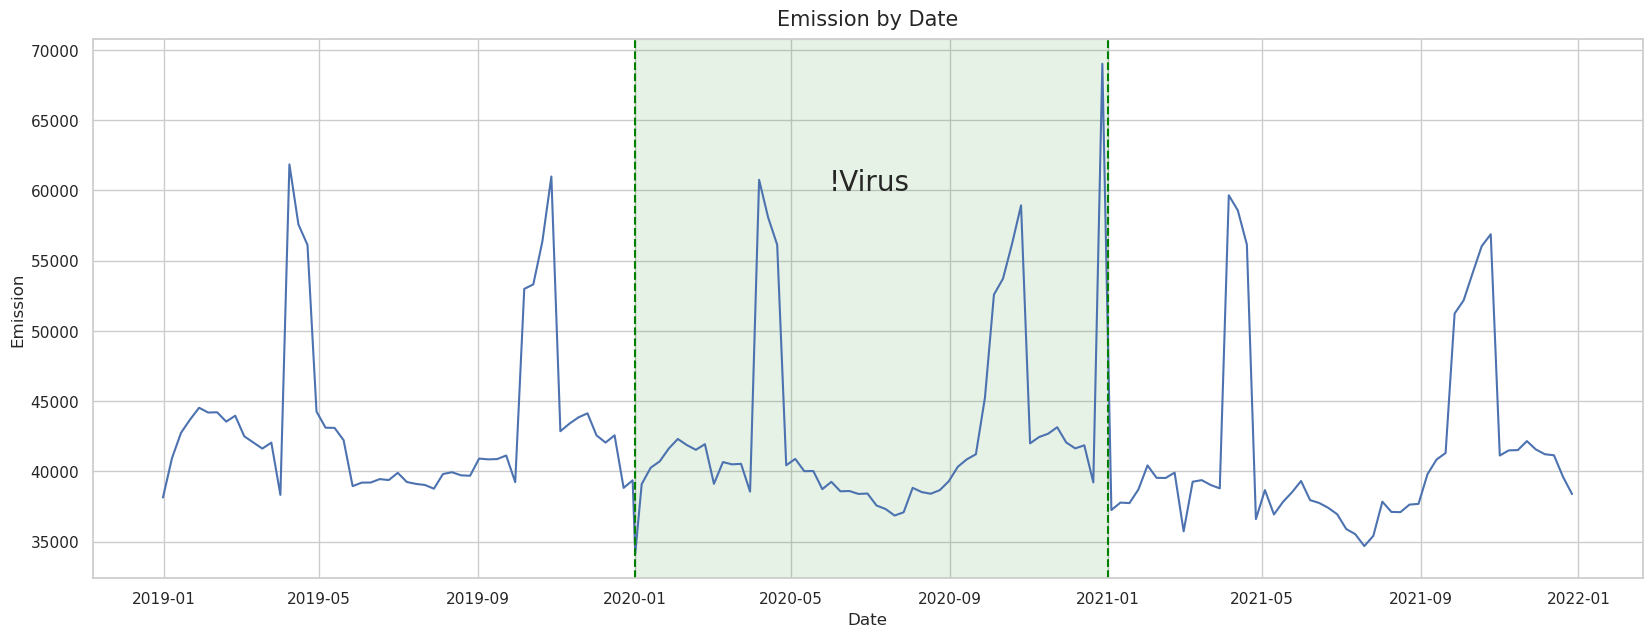

In [16]:
filtered_data = df.loc[df['test'] == 0]
grouped_data = filtered_data.groupby(['date'])['emission'].sum()

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.lineplot(data=grouped_data.reset_index(), x='date', y='emission', ax=ax)

ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
ax.axvline(pd.Timestamp('2020-01-01'), linestyle="--", color='green')
ax.axvline(pd.Timestamp('2021-01-01'), linestyle="--", color='green')

ax.text(pd.Timestamp('2020-05-30'), 60000, "!Virus", size=20)

ax.set_xlabel('Date')
ax.set_ylabel('Emission')
ax.set_title('Emission by Date', size=15, pad=10)

plt.show()

In [17]:
cols_to_pca = df.columns[5:68]

data_to_pca = df[cols_to_pca]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_pca)

n_components = 5
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

df_reset_index = df.reset_index(drop=True)

df = pd.concat([df_reset_index, pca_df], axis=1)

In [18]:
df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + (np.sin(np.radians(15)) * df['latitude'])

df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + (np.sin(np.radians(15)) * df['longitude'])

df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + (np.sin(np.radians(30)) * df['latitude'])

df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + (np.sin(np.radians(30)) * df['longitude'])

In [19]:
df['season'] = df['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)

In [20]:
df['holidays'] = (df['week_no'].isin([0, 51, 12, 30]))

In [21]:
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)

df['week_sin'] = np.sin(2 * np.pi * df['week_no']/53)
df['week_cos'] = np.cos(2 * np.pi * df['week_no']/53)

df['season_sin'] = np.sin(2 * np.pi * df['season']/4)
df['season_cos'] = np.cos(2 * np.pi * df['season']/4)

In [22]:
train = df.loc[df['test'] == 0]
test = df.loc[df['test'] == 1]

In [23]:
from sklearn.cluster import KMeans
import haversine as hs

km_train = train.groupby(by=['latitude', 'longitude'], as_index=False)['emission'].mean()
model = KMeans(n_clusters = 7, random_state = 42)
model.fit(km_train)
yhat_train = model.predict(km_train)
km_train['kmeans_group'] = yhat_train

km_train['is_zero'] = km_train['emission'].apply(lambda x: 'no_emission_recorded' if x==0 else 'emission_recorded')

max_lat_lon_emission = km_train.loc[km_train['emission']==km_train['emission'].max(), ['latitude', 'longitude']]
km_train['distance_to_max_emission'] = km_train.apply(lambda x: hs.haversine((x['latitude'], x['longitude']), (max_lat_lon_emission['latitude'].values[0], max_lat_lon_emission['longitude'].values[0])), axis=1)

train = train.merge(km_train[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])
test = test.merge(km_train[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])

In [24]:
features = [
            'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y',
            'season', 'holidays', 'month_sin', 'month_cos', 'week_sin',
            'week_cos', 'season_sin', 'season_cos', 'kmeans_group', 'distance_to_max_emission'
           ]

target = 'emission'

In [25]:
def best_params(X_train, y_train):
    
    param_space = {
        'model__learning_rate': Real(0.01, 0.1, 'log-uniform'),
        'model__n_estimators': Integer(800, 1200),
        'model__max_depth': Integer(5, 15),
        'model__subsample': Real(0.7, 1.0),
        'model__colsample_bytree': Real(0.7, 1.0),
        'model__reg_alpha': Real(0, 0.5, 'uniform'),
        'model__reg_lambda': Real(0, 0.5, 'uniform'),
        'model__min_child_samples': Integer(5, 20),
        'model__scale_pos_weight': Real(1, 5),
        'model__num_leaves': Integer(30, 150),
        'model__min_split_gain': Real(0, 2),
    }

    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LGBMRegressor(device='gpu', random_state=42))
        ])

    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    rmse_scorer = make_scorer(rmse, greater_is_better=False)

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=3,
        cv=3,
        n_jobs=-1,
        scoring=rmse_scorer,
        random_state=42
    )

    bayes_search.fit(X_train, y_train)

    best_params = bayes_search.best_params_
    best_score = -bayes_search.best_score_
    best_model = bayes_search.best_estimator_

    return best_model, best_params, best_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


                                             
*********************************************
                                             
Best score: 13.433968374915297
                                             
*********************************************
                                             


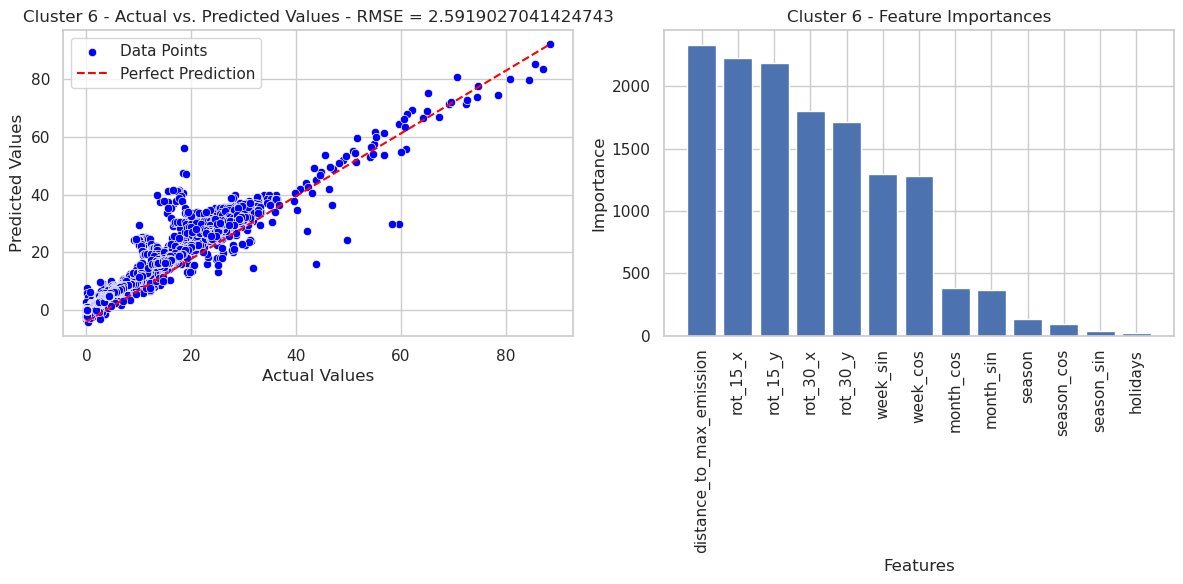

                                             
*********************************************
                                             
Best score: 33.00355240343991
                                             
*********************************************
                                             


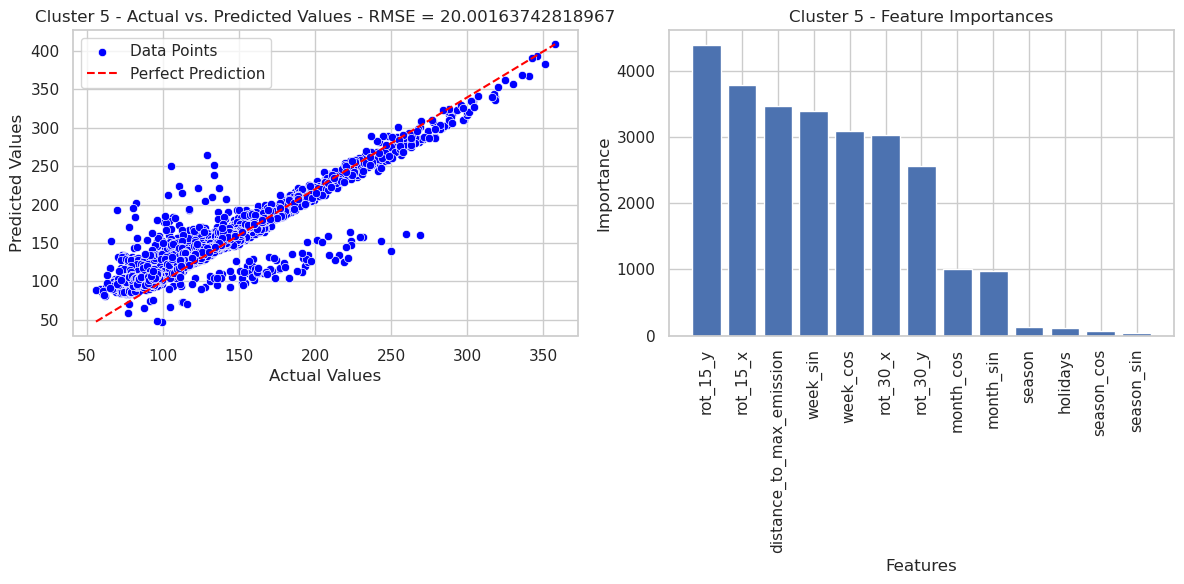

                                             
*********************************************
                                             
Best score: 26.489122082884354
                                             
*********************************************
                                             


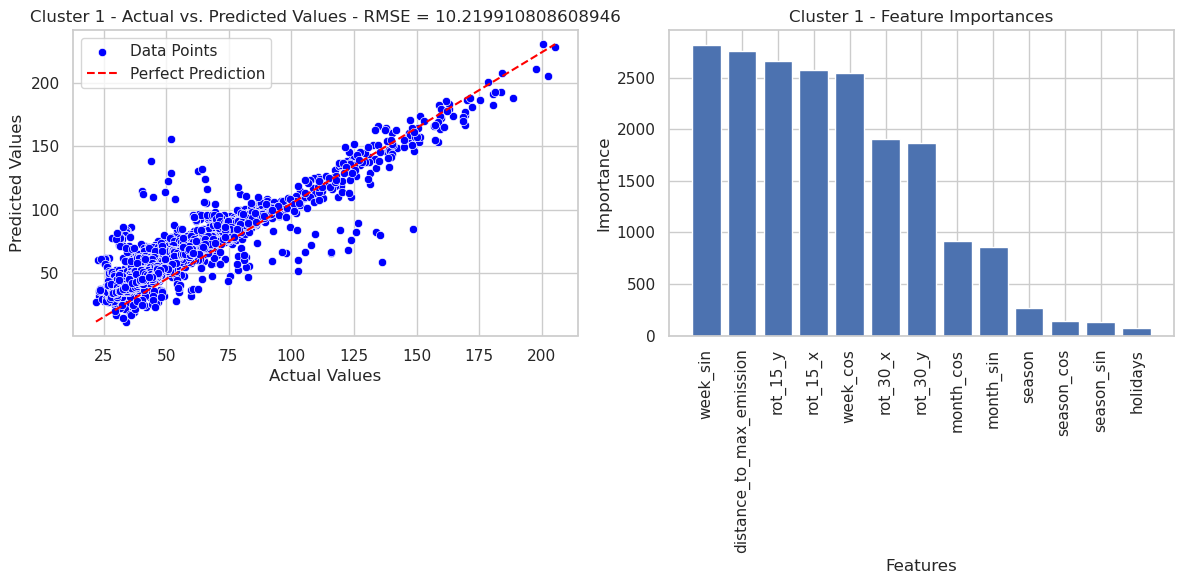

                                             
*********************************************
                                             
Best score: 70.74053979715254
                                             
*********************************************
                                             


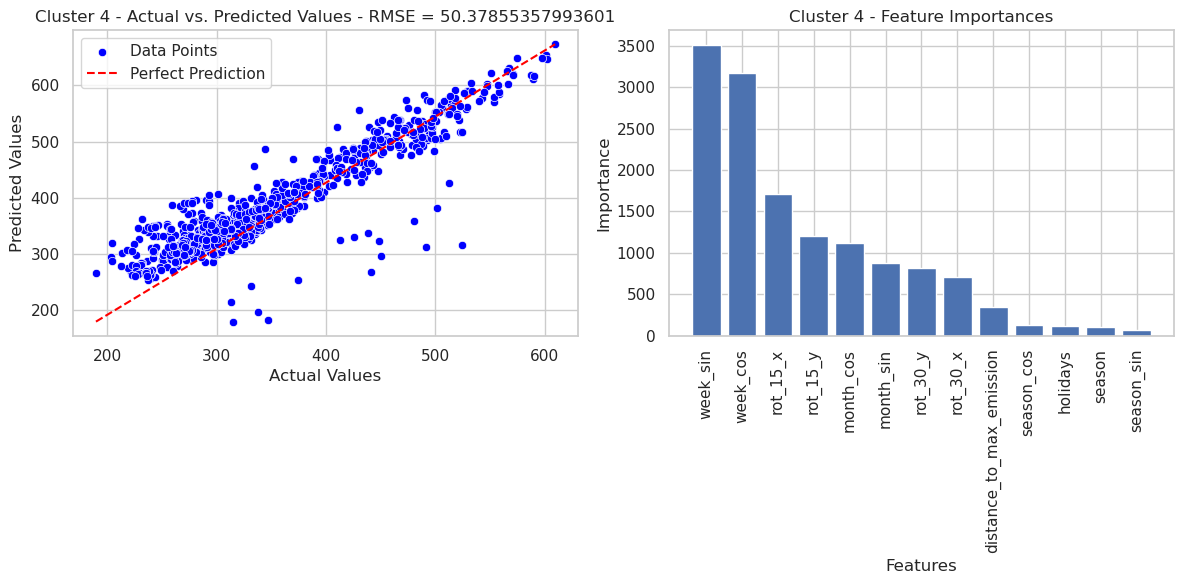

                                             
*********************************************
                                             
Best score: 45.4085721295047
                                             
*********************************************
                                             


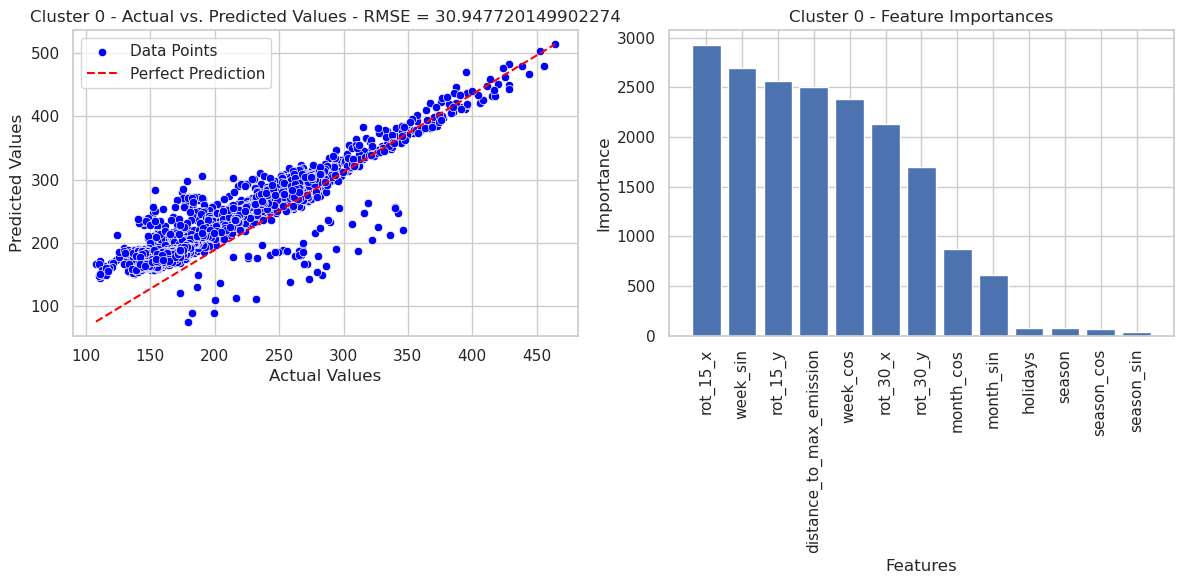

                                             
*********************************************
                                             
Best score: 214.52639978103684
                                             
*********************************************
                                             


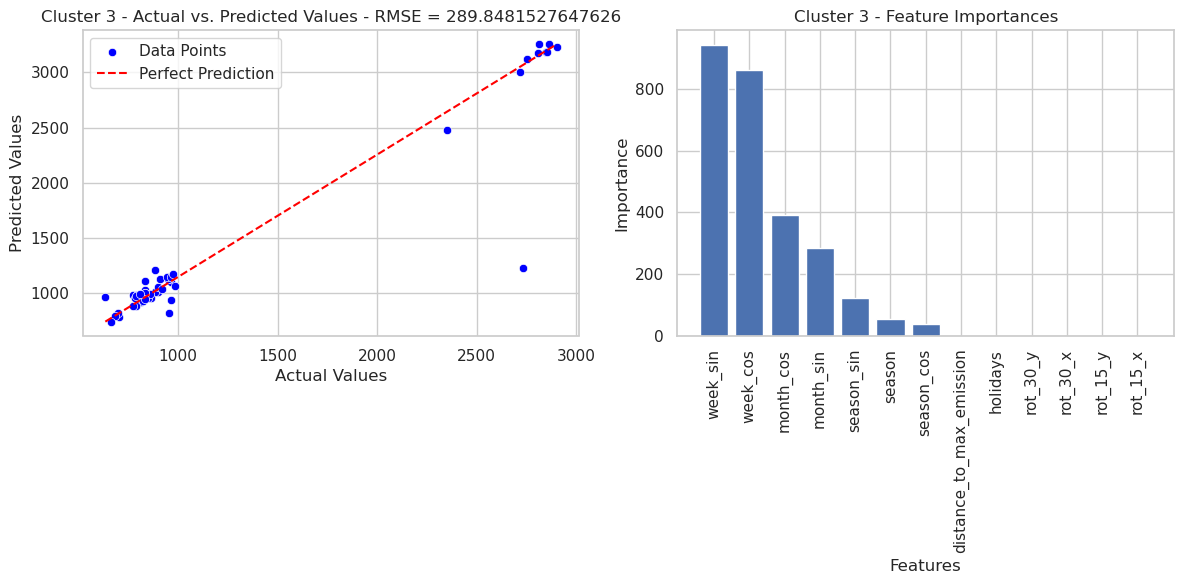

                                             
*********************************************
                                             
Best score: 210.42351041939887
                                             
*********************************************
                                             


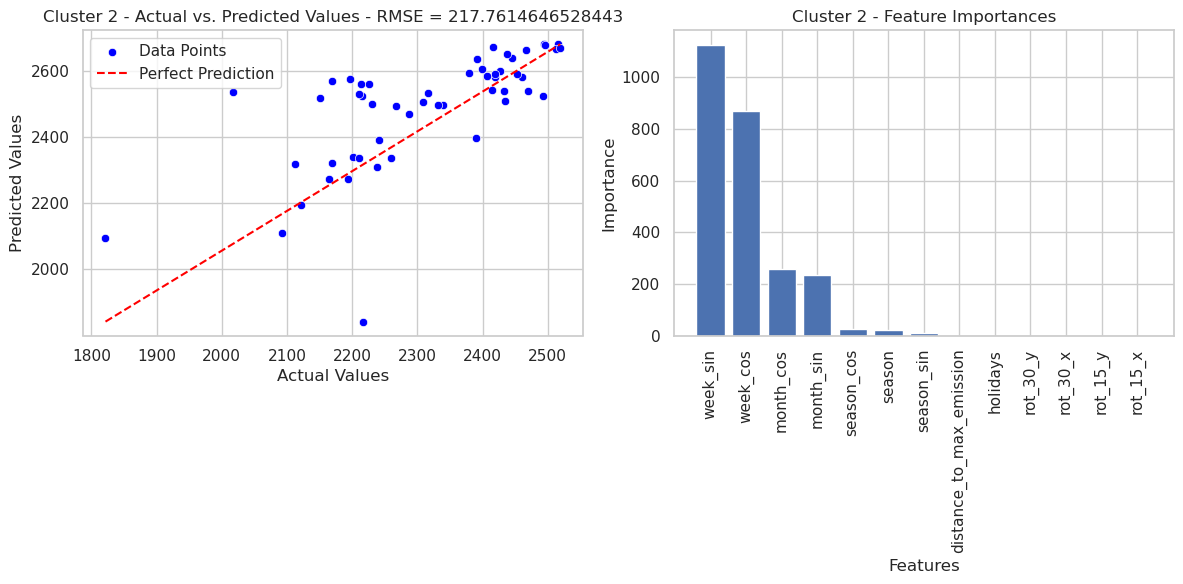

                                             
*********************************************
Mean scores = 88.82133458405518


In [26]:
validation = train[train.year == 2021]
clusters = train["kmeans_group"].unique()
params_per_cluster = {}
scores = []

for i in range(len(clusters)):
               
    cluster = clusters[i]
    
    train_c = train[train["kmeans_group"] == cluster]
    
    X_train = train_c[train_c.year < 2021][features].drop(columns = ["kmeans_group"])
    y_train = train_c[train_c.year < 2021][target].copy()
    X_val = train_c[train_c.year >= 2021][features].drop(columns = ["kmeans_group"])
    y_val = train_c[train_c.year >= 2021][target].copy()
    
    
    pipeline, params, best_score = best_params(X_train, y_train)
    
    params_per_cluster[cluster] = {key.replace('model__', ''): value for key, value in params.items()}
    
    print(' '*45)
    print('*'*45)
    print(' '*45)
    print(f"Best score: {best_score}")
    print(' '*45)
    print('*'*45)
    print(' '*45)
    

    lgb_pred = pipeline.predict(X_val) * 1.07
    rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
    scores.append(rmse)
        
   # Scatter Plot and Feature Importances Combined
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Scatter Plot
    data = pd.DataFrame({'Actual': y_val, 'Predicted': lgb_pred})
    sns.scatterplot(data=data, x='Actual', y='Predicted', color='blue', label='Data Points', ax=axes[0])
    axes[0].plot([min(y_val), max(y_val)], [min(lgb_pred), max(lgb_pred)], color='red', linestyle='--', label='Perfect Prediction')
    axes[0].set_title(f'Cluster {cluster} - Actual vs. Predicted Values - RMSE = {rmse}')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].legend()


    lgb_model = pipeline.named_steps['model']

    importances = lgb_model.feature_importances_
    feature_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]

    axes[1].bar(range(len(importances)), importances[sorted_idx])
    axes[1].set_xticks(range(len(importances)))
    axes[1].set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)
    axes[1].set_xlabel("Features")
    axes[1].set_ylabel("Importance")
    axes[1].set_title(f"Cluster {cluster} - Feature Importances")

    plt.tight_layout()
    plt.show()
    
print(" "*45)
print("*"*45)

print(f"Mean scores = {np.mean(scores)}")

In [27]:
sample.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94


In [28]:
clusters = train["kmeans_group"].unique()

for i in range(len(clusters)):
    
    cluster = clusters[i]
    
    train_c = train[train["kmeans_group"] == cluster]
    
    test_c = test[test["kmeans_group"] == cluster][features].drop(columns = ["kmeans_group"])
    
    X = train_c[features].drop(columns = ["kmeans_group"])
    y = train_c[target].copy()
                               
    lgb_model = LGBMRegressor(
                            **params_per_cluster[cluster],
                            random_state=42,
                            device='gpu'
                        )
    
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', lgb_model)
        ])
    
    pipeline.fit(X, y)

    lgb_pred = pipeline.predict(test_c) * 1.07
    
    test.loc[test["kmeans_group"] == cluster, "emission"] = lgb_pred

In [29]:
sample['emission'] = test["emission"]
sample["emission"] = sample["emission"].apply(lambda x: max(x, 0))
sample

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.009216
1,ID_-0.510_29.290_2022_01,4.119784
2,ID_-0.510_29.290_2022_02,4.265215
3,ID_-0.510_29.290_2022_03,4.534140
4,ID_-0.510_29.290_2022_04,4.618069
...,...,...
24348,ID_-3.299_30.301_2022_44,31.577625
24349,ID_-3.299_30.301_2022_45,31.892125
24350,ID_-3.299_30.301_2022_46,31.892125
24351,ID_-3.299_30.301_2022_47,32.088975
